In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import gym
from gym import spaces
import random

In [9]:
folder_path = '../csv'
all_csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

df_list = [pd.read_csv(file) for file in all_csv_files]

df = pd.concat(df_list, ignore_index=True)

print(df.shape)
df.head()

(3606, 4)


,Unnamed: 0,TxnDate,TxnTime,Consumption
0,0,01 Feb 2022,14:41:48,1.016
1,1,01 Feb 2022,17:28:44,0.928
2,2,01 Feb 2022,19:51:07,0.988
3,3,01 Feb 2022,07:26:39,1.126
4,4,01 Feb 2022,05:20:47,0.886


In [10]:
print(df.dtypes)
df['Consumption'].describe()

Unnamed: 0       int64
TxnDate         object
TxnTime         object
Consumption    float64
dtype: object


count    3606.000000
mean        2.781508
std         2.961248
min         0.000000
25%         0.948000
50%         1.032000
75%         4.005500
max        27.284000
Name: Consumption, dtype: float64

In [12]:
df['date']=pd.to_datetime(df['TxnDate'])
df['datetime'] = pd.to_datetime(df['TxnDate'].astype(str) + ' ' + df['TxnTime'].astype(str))

# df['timestamp']=pd.to_datetime(df['TxnTime'])
df.sort_values(by='datetime', inplace=True)

df['daily_consumption'] = (
    df.groupby(df['date'].dt.date)['Consumption']
    .transform('sum')
)

df.reset_index(drop=True, inplace=True)
df.head()

,Unnamed: 0,TxnDate,TxnTime,Consumption,date,datetime,daily_consumption
0,77476,01 Jan 2022,00:22:28,1.030,2022-01-01,2022-01-01 00:22:28,65.462
1,76780,01 Jan 2022,00:42:33,0.904,2022-01-01,2022-01-01 00:42:33,65.462
2,76954,01 Jan 2022,01:01:51,0.904,2022-01-01,2022-01-01 01:01:51,65.462
3,76548,01 Jan 2022,01:41:48,1.850,2022-01-01,2022-01-01 01:41:48,65.462
4,77070,01 Jan 2022,02:22:52,1.878,2022-01-01,2022-01-01 02:22:52,65.462


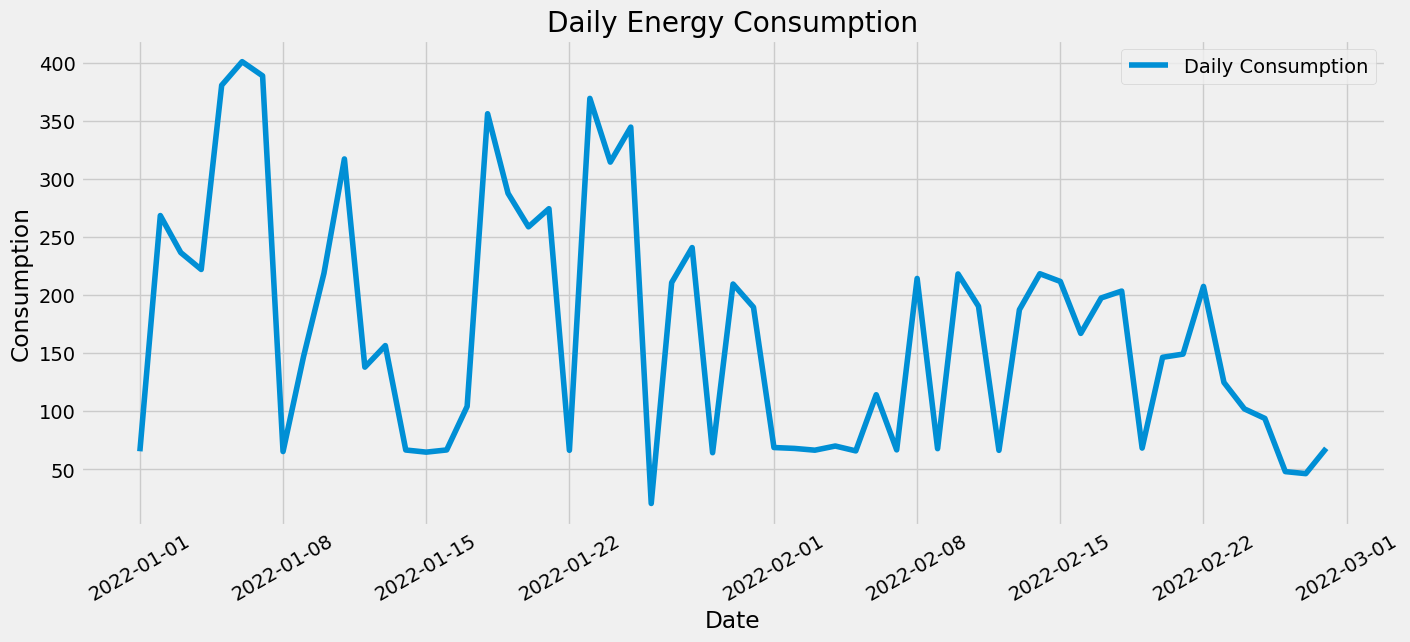

In [13]:
#df.set_index('date', inplace=True)

plt.style.use('fivethirtyeight')

plt.figure(figsize=(15, 6))
plt.plot(df.date, df['daily_consumption'], label='Daily Consumption')
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("Daily Energy Consumption")
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.show()

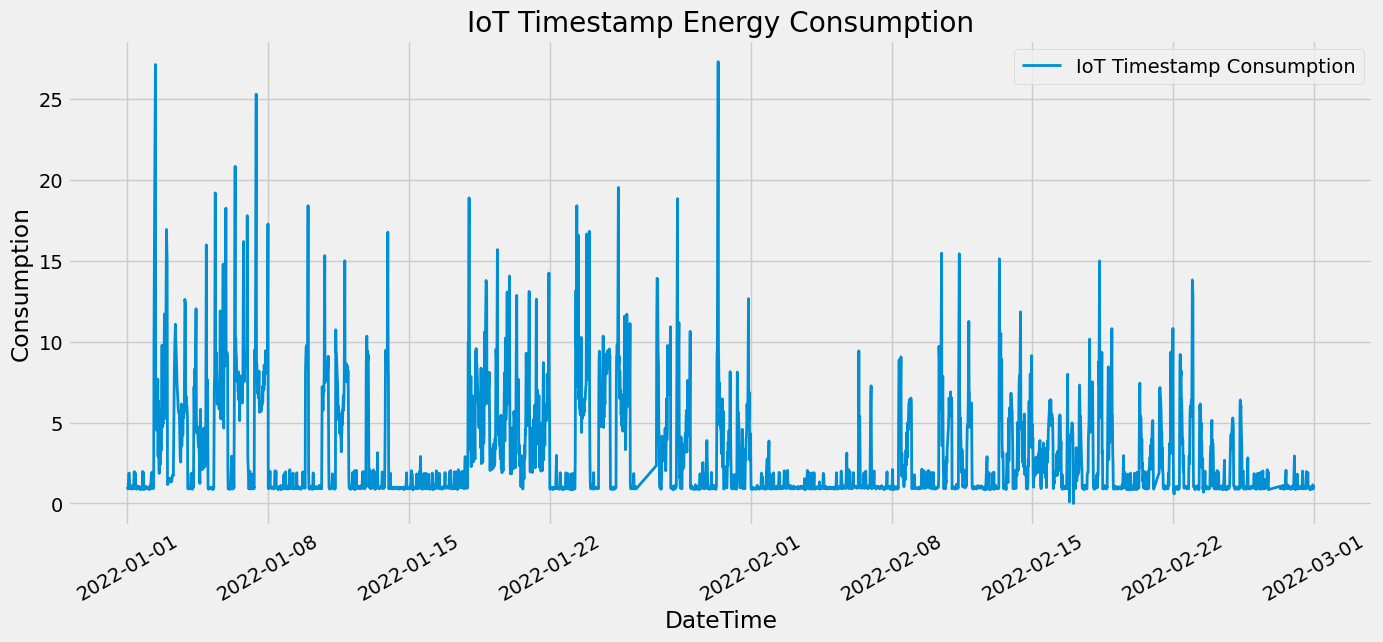

In [14]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15, 6))
plt.plot(df.datetime, df['Consumption'], label='IoT Timestamp Consumption', linewidth=2)
plt.xlabel("DateTime")
plt.ylabel("Consumption")
plt.title("IoT Timestamp Energy Consumption")
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# df.reset_index(inplace=True)
# df.head()

In [15]:
# Anomaly Detection Environment
class AnomalyDetectionEnv:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.action_space = spaces.Discrete(2)  # 0: no anomaly, 1: anomaly
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        self.flagged_anomalies = []  # Store flagged anomalies

    def step(self, action):
        # Get the current data point and index
        current_value = self.data[self.current_step]
        current_index = self.current_step
        
        # If the agent flags it as an anomaly, store it
        if action == 1:  # 1 means anomaly
            self.flagged_anomalies.append((current_index, current_value))
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data)
        
        # Return observation, reward, done, and info
        return np.array([current_value]), 0, done, {}

    def reset(self):
        self.current_step = 0
        self.flagged_anomalies = []  # Reset anomalies for a new episode
        return np.array([self.data[self.current_step]])

In [16]:
class QLearningAgent:
    def __init__(self, action_size):
        self.action_size = action_size
        self.q_table = {}
        self.alpha = 0.01  # Learning rate
        self.gamma = 0.95  # Discount factor
        self.epsilon = 0.75  # Exploration rate (1.0)
        self.epsilon_decay = 0.50 # 0.99
        self.epsilon_min = 0.01 # 0.1

    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.action_size - 1)
        return np.argmax(self.q_table.get(tuple(state.flatten()), [0]*self.action_size))

    def update_q_value(self, state, action, reward, next_state):
        state_key = tuple(state.flatten())
        next_state_key = tuple(next_state.flatten())
        current_q = self.q_table.get(state_key, [0]*self.action_size)[action]
        max_future_q = max(self.q_table.get(next_state_key, [0]*self.action_size))
        
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_future_q)
        if state_key not in self.q_table:
            self.q_table[state_key] = [0] * self.action_size
        self.q_table[state_key][action] = new_q

In [17]:
# Training the agent
env = AnomalyDetectionEnv(df['Consumption'].values)
agent = QLearningAgent(env.action_space.n)
num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        # Agent selects an action
        action = agent.get_action(state)
        # Environment responds to the action
        next_state, reward, done, _ = env.step(action)
        agent.update_q_value(state, action, reward, next_state)
        state = next_state
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

In [18]:
# Print flagged anomalies
# print("Flagged anomalies:", env.flagged_anomalies)

In [19]:
# Extract anomaly indexes
anomaly_indexes = {index for index, value in env.flagged_anomalies}

# Add a new column to the DataFrame
df['Is_Anomaly'] = df.index.isin(anomaly_indexes).astype(int)

In [20]:
df['Is_Anomaly'].sum()

np.int64(10)

In [38]:
df[df.Is_Anomaly==1]

,Unnamed: 0,TxnDate,TxnTime,Consumption,date,datetime,daily_consumption,Is_Anomaly
382,85135,07 Jan 2022,08:06:46,9.496,2022-01-07,2022-01-07 08:06:46,388.762,1
557,78796,10 Jan 2022,02:42:50,0.900,2022-01-10,2022-01-10 02:42:50,218.740,1
869,90854,14 Jan 2022,22:34:06,0.938,2022-01-14,2022-01-14 22:34:06,66.572,1
1655,444,28 Jan 2022,17:17:25,3.744,2022-01-28,2022-01-28 17:17:25,240.878,1
1744,524,30 Jan 2022,04:11:40,0.984,2022-01-30,2022-01-30 04:11:40,209.498,1
1984,81,02 Feb 2022,23:07:23,1.070,2022-02-02,2022-02-02 23:07:23,67.944,1
2593,763,12 Feb 2022,10:52:30,1.082,2022-02-12,2022-02-12 10:52:30,66.264,1
3280,1411,23 Feb 2022,06:06:52,0.980,2022-02-23,2022-02-23 06:06:52,124.748,1
3378,1516,24 Feb 2022,19:15:59,1.180,2022-02-24,2022-02-24 19:15:59,101.980,1
3395,1568,25 Feb 2022,01:46:26,0.872,2022-02-25,2022-02-25 01:46:26,93.772,1


In [21]:
# Evaluate the agent
# state = env.reset()
# done = False
# total_reward = 0

# while not done:
#     action = agent.get_action(state)
#     next_state, reward, done, _ = env.step(action)
#     total_reward += reward
#     state = next_state

# print(f'Total reward during evaluation: {total_reward}')